# *Hinode*/XRT Instrument Sandbox
Create an XRT imaging instrument.

In [82]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import hissw
from sunpy.net import Fido,attrs as a
import astropy.units as u
import astropy.convolution
import sunpy.map
import sunpy.util.metadata
import astropy.io

%matplotlib inline

In [ ]:
ssw_script = '''
wave_resp = make_xrt_wave_resp(contam_time='2017-Jan-01 09:00:00')
temp_resp = make_xrt_temp_resp(wave_resp,/apec_default) 
'''
ssw = hissw.ScriptMaker(ssw_packages=['hinode/xrt'],ssw_paths=['xrt'])
xrt_response = ssw.run(ssw_script,verbose=False,save_vars=['wave_resp','temp_resp'])

In [ ]:
xrt_response_functions = {}

In [ ]:
for r in xrt_response['temp_resp']:
    name = '_'.join((r['name'].decode('utf-8').split(';')[0]).split('-'))
    temperature = r['temp'][np.where(r['temp'] != 0.0)].astype(np.float64)
    response = r['temp_resp'][np.where(r['temp'] != 0.0)].astype(np.float64)
    xrt_response_functions[name] = {'temperature':temperature, 'response':response}

In [ ]:
plt.figure(figsize=(12,8))
for i,k in enumerate(xrt_response_functions):
    if len(k.split('/')) > 1:
        continue
    plt.plot(xrt_response_functions[k]['temperature'],xrt_response_functions[k]['response'],
             color=f'C{i%10}',label=k)
plt.xscale('log')
plt.yscale('log')
#plt.xlim(5e5,1e8)
plt.ylim(1e-29,5e-25)
plt.legend()

In [ ]:
xrt_dict = {}
xrt_dict['name'] = 'Hinode_XRT'
xrt_dict['description'] = 'Temperature response functions for the single-filter-wheel channels of the X-Ray Telescope (XRT) on Hinode'

In [ ]:
for k in xrt_response_functions:
    # Skip those channels with multiple filter wheels
    if len(k.split('/')) > 1:
        continue
    xrt_dict[k] = {
        'temperature_response_x': xrt_response_functions[k]['temperature'].tolist(),
        'temperature_response_x_units': (u.K).to_string(),
        'temperature_response_y': xrt_response_functions[k]['response'].tolist(),
        'temperature_response_y_units': (u.count * u.cm**5 / u.s / u.pixel).to_string(),
    }

Go through and manually set the filter wheel combinations. Here, each "channel" is effectively a combination of two filter wheels. Here, we only include those combinations where one of the filter wheels is open.

In [ ]:
# Filter wheel 2 is open
xrt_dict['Al_med']['filter_wheel_1'] = 'Al_med'
xrt_dict['Al_med']['filter_wheel_2'] = 'open'
xrt_dict['Al_poly']['filter_wheel_1'] = 'Al_poly'
xrt_dict['Al_poly']['filter_wheel_2'] = 'open'
xrt_dict['Be_med']['filter_wheel_1'] = 'Be_med'
xrt_dict['Be_med']['filter_wheel_2'] = 'open'
xrt_dict['Be_thin']['filter_wheel_1'] = 'Be_thin'
xrt_dict['Be_thin']['filter_wheel_2'] = 'open'
xrt_dict['C_poly']['filter_wheel_1'] = 'C_poly'
xrt_dict['C_poly']['filter_wheel_2'] = 'open'
# Filter wheel 1 is open
xrt_dict['Al_mesh']['filter_wheel_1'] = 'open'
xrt_dict['Al_mesh']['filter_wheel_2'] = 'Al_mesh'
xrt_dict['Al_thick']['filter_wheel_1'] = 'open'
xrt_dict['Al_thick']['filter_wheel_2'] = 'Al_thick'
xrt_dict['Be_thick']['filter_wheel_1'] = 'open'
xrt_dict['Be_thick']['filter_wheel_2'] = 'Be_thick'
xrt_dict['Ti_poly']['filter_wheel_1'] = 'open'
xrt_dict['Ti_poly']['filter_wheel_2'] = 'Ti_poly'

In [ ]:
with open('/Users/willbarnes/Documents/work/codes/synthesizAR/synthesizAR/instruments/data/hinode_xrt.json','w') as f:
    json.dump(xrt_dict,f,indent=4,sort_keys=True)

## XRT Observation Sandbox

In [ ]:
res = Fido.search(a.Time('2009/10/23 06:00:00','2009/10/23 06:03:30'),a.Instrument('xrt'))

In [ ]:
res

In [ ]:
files = Fido.fetch(res)

In [ ]:
files

In [92]:
foo = sunpy.map.Map('/Users/willbarnes/sunpy/data/l1_xrt20091023_060304_1.fits')

In [93]:
foo.meta['ctype1'] = 'HPLN-TAN'
foo.meta['ctype2'] = 'HPLT-TAN'

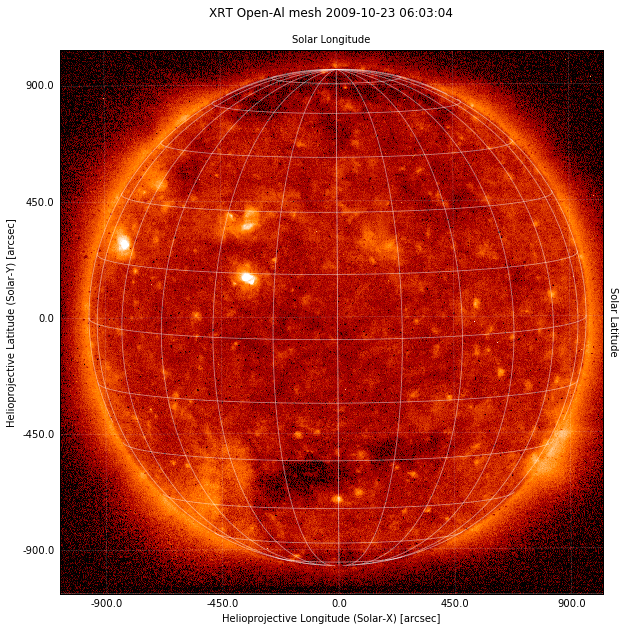

In [94]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=foo)
foo.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(10,vmin=0,vmax=2e3))
foo.draw_grid()

In [4]:
def xrt_psf(lon,lat):
    r = np.sqrt(lon**2 + lat**2)
    a = 1.31946
    sigma = 2.19256
    gamma = 1.24891
    if r <= 3.4176:
        return a*np.exp(-(r/a)**2)/(gamma**2 + r**2)
    elif 3.4176 < r <= 5:
        return 0.03/r
    elif 5 < r <= 11.1:
        return 0.15/r
    elif r >= 11.1:
        return (11.1)**2*0.15/(r**4)

In [57]:
lon = np.linspace(foo.bottom_left_coord.Tx.value,foo.top_right_coord.Tx.value,250+1)
lat = np.linspace(foo.bottom_left_coord.Ty.value,foo.top_right_coord.Ty.value,250+1)

In [58]:
lon_grid,lat_grid = np.meshgrid(lon,lat)

In [59]:
psf = np.vectorize(xrt_psf)(lon_grid,lat_grid)

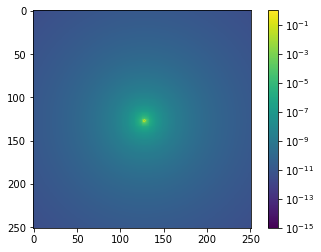

In [60]:
plt.imshow(psf,norm=matplotlib.colors.LogNorm(vmin=1e-15,vmax=1))
plt.colorbar()

In [61]:
xrt_psf_kernel = astropy.convolution.kernels.CustomKernel(psf)

In [62]:
dummy_image = np.random.rand(int(foo.dimensions.x.value),
                             int(foo.dimensions.y.value)
                            )

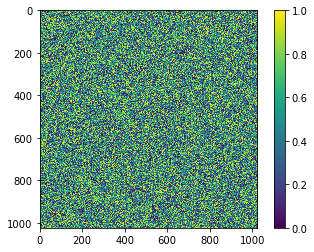

In [70]:
plt.imshow(dummy_image,vmin=0,vmax=1)
plt.colorbar()

In [68]:
dummy_spread = astropy.convolution.convolve_fft(dummy_image,xrt_psf_kernel)

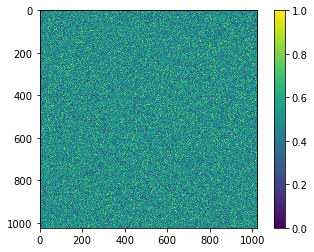

In [69]:
plt.imshow(dummy_spread,vmin=0,vmax=1)
plt.colorbar()

In [80]:
sunpy.map.Map(dummy_spread,
              sunpy.util.metadata.MetaDict({'wavelnth': f'{u.Quantity(np.nan).value}'})).save('/Users/willbarnes/Desktop/foo.fits')

In [91]:
foo.save('xrt_foo.fits',output_verify='ignore')

ValueError: Floating point nan values are not allowed in FITS headers.

In [83]:
xrt_hdu = astropy.io.fits.open('/Users/willbarnes/sunpy/data/l1_xrt20091023_060304_1.fits')

In [88]:
xrt_hdu[0].header

SIMPLE  =                    T / Written by IDL:  Wed Oct 28 06:03:10 2015      
BITPIX  =                  -32 /Real*4 (floating point)                         
NAXIS   =                    2 /                                                
NAXIS1  =                 1024 /                                                
NAXIS2  =                 1024 /                                                
DATE    = '2009-10-29T15:33:02.000' /                                           
DATE_RF0= '2009-10-29T15:33:02.000' /                                           
DATE_RF1= '2015-04-13T00:06:45.814' /                                           
SATELLIT=                   33 /                                                
TELESCOP= 'HINODE  '           /                                                
INSTRUME= 'XRT     '           /                                                
TIMESYS = 'UTC (TBR)'          /                                                
MDP_CLK =           26331351